In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import os
from google.colab.patches import cv2_imshow

Kaggle task of predicting location of facial keypoints like eyebrows, lips etc given an image of a face.Training has been done on training.csv and later tested on test.csv , made a simple CNN architecture model since images are in grayscale. Using sigmoid in the last layer and calculating mean squared error b/w true labels and predicted labels.

importing modules


In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
os.chdir('./drive/My Drive/kaggle')

reading all csv to pandas dataframe

In [0]:
train_data = pd.read_csv('./training.csv')  
test_data = pd.read_csv('./test.csv')
lookid_data = pd.read_csv('./IdLookupTable.csv')

In [0]:
train_data.fillna(method = 'ffill',inplace = True)

replacing any Nan or null value with last value in the column/

In [0]:
train_data.isnull().any().value_counts()

False    31
dtype: int64

In [0]:
train_data.head()

In [0]:
train_data.shape

(7049, 31)

In [0]:
imag = []
for i in range(0,train_data.shape[0]):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)

In [0]:
image_list = np.array(imag,dtype = 'float')
X_train = image_list.reshape(-1,96,96)
x_train = X_train.reshape(-1,96,96,1)
x_train = x_train/255

normalizing training image data

In [0]:
X_train.shape

(7049, 96, 96)

(96, 96)


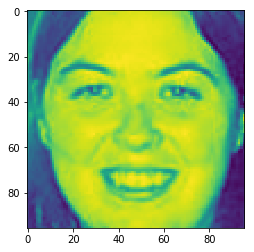

(96, 96)


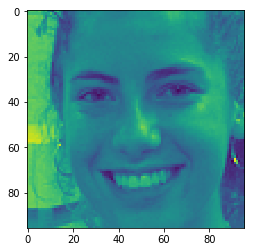

In [0]:
for i in X_train[5000:5002]:
    print(i.shape)
    plt.imshow(i)
    plt.show()

In [0]:
y_train = np.array(train_data.iloc[:,:-1])

getting training labels i.e facial keypoints coordinates

In [0]:
y_train.shape

(7049, 30)

In [0]:
def visualize(img,coor):
  x_coordinates = [coor[i] for i in range(0,len(coor),2)]
  y_coordinates = [coor[i] for i in range(1,len(coor),2)]
  implot = plt.imshow(img,cmap='gray')
  plt.scatter(x=x_coordinates, y=y_coordinates, c='r', s=40)

plotting labels on the corresponding image for better visualization

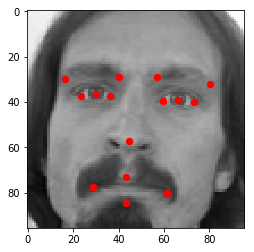

In [0]:
visualize(X_train[0],y_train[0])

In [0]:
normalized_ytrain = y_train/96

normalizing labels between 0-1 so the model can regress between 0-1

In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np
from keras import backend as K
from keras.initializers import he_normal

Using TensorFlow backend.


In [0]:
K.set_learning_phase(1)

In [0]:
model = Sequential()
model.add(Conv2D(48,3,input_shape=(96,96,1),activation='relu'))
model.add(Conv2D(48,3,activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Conv2D(72,2,activation='relu'))
model.add(Conv2D(72,2,activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Conv2D(96,2,activation='relu'))
model.add(Conv2D(96,2,activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
x_train = x_train.astype('float32')
normalized_ytrain = normalized_ytrain.astype('float32')

In [0]:
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae','accuracy'])

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint("best_weights.h5", 'val_loss', verbose=1,save_best_only=True)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 48)        480       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 72)        13896     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 72)        20808     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 72)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 96)        27744     
__________

In [0]:
model.fit(x_train,normalized_ytrain,batch_size=32,epochs=100, verbose=1, callbacks=[model_checkpoint],validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 5639 samples, validate on 1410 samples
Epoch 1/100
5639/5639 [==============================] - 10s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0297 - acc: 0.5739 - val_loss: 7.2857e-04 - val_mean_absolute_error: 0.0179 - val_acc: 0.6390

Epoch 00001: val_loss improved from inf to 0.00073, saving model to best_weights.h5
Epoch 2/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0219 - acc: 0.6180 - val_loss: 7.1194e-04 - val_mean_absolute_error: 0.0178 - val_acc: 0.6752

Epoch 00002: val_loss improved from 0.00073 to 0.00071, saving model to best_weights.h5
Epoch 3/100
5639/5639 [==============================] - 7s 1ms/step - loss: 7.9598e-04 - mean_absolute_error: 0.0188 - acc: 0.7161 - val_loss: 8.1031e-04 - val_mean_absolute_error: 0.0203 - val_acc: 0.7277

Epoch 00003: val_loss did not improve from 0.00071
Epoch 4/100
5639/5639 [==============================] - 7s 1ms/

In [0]:
ans = model.predict(np.expand_dims(x_train[0],axis=0))

In [0]:
new_imag = []
for i in range(0,test_data.shape[0]):
    img = test_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    new_imag.append(img)

trying on new test dataset to see performance of our model

In [0]:
image_list = np.array(new_imag,dtype = 'float')
X_test = image_list.reshape(-1,96,96)

In [0]:
X_test.shape

(1783, 96, 96)

In [0]:
x_test = X_test.reshape(-1,96,96,1)
x_test = x_test/255

In [0]:
ans = model.predict(np.expand_dims(x_test[220],axis=0))

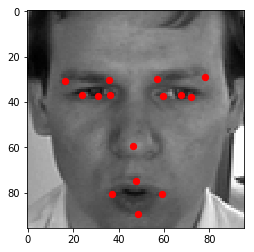

In [0]:
visualize(X_test[220],ans[0]*96)

In [0]:
ans = model.predict(np.expand_dims(x_test[660],axis=0))

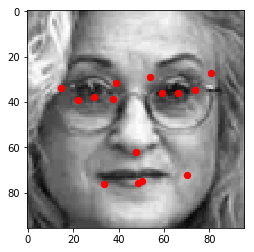

In [0]:
visualize(X_test[660],ans[0]*96)

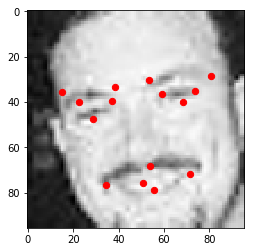

In [0]:
ans = model.predict(np.expand_dims(x_test[900],axis=0))
visualize(X_test[900],ans[0]*96)

RESULT : As you can see the model performs great on new data also.